In [1]:
# import torch
import pandas as pd
import json,os,sqlite3

`ajId`:ID of the case,   
`ajName` is the case name,   
`ajjbqk` 基本事实,  
`pjjg` 判决,    
`qw`  全部内容,   
`writId` 文档ID,   
`writName` 文档名称   

In [2]:
def insert_by_batch(con,command,array):
	cur = con.cursor()
	for batch in [array[i:i+2000] for i in range(len(array))[::2000]]:
		cur.executemany(command,batch)
	con.commit()
con = sqlite3.connect("index.db")
cur = con.cursor()
charges = json.load(open("data/documents/common_charge.json",encoding="utf-8"))
query_related = {v for key in charges for v in charges[key][:100] if v.endswith(".json")}
with open("data/query.json",encoding="utf-8") as f:
	for i in f.readlines():
		t =  json.loads(i)
		if t["path"].endswith(".json"):
			query_related.add(t["path"])
data = []
for item in query_related:
	obj = json.load(open("data/documents/documents/{}".format(item),encoding="utf-8"))
	obj["path"] = item
	data.append(obj)
# going_inserted = [(index,
# 				  i.get("ajName",""),
# 				  i.get("ajjbqk",""),
# 				  i.get("cpfxgc",""),
# 				  i.get("pjjg",""),
# 				  i.get("writName",""),
# 				  i["writId"],
# 				  i["path"]) for index,i in enumerate(data)]
# insert_by_batch(con,"insert or ignore into cases values (?,?,?,?,?,?,?,?)",going_inserted)

In [16]:
ret = dict()
class Word:
	def __init__(self,document_id,tf):
		self.document_id = document_id
		self.tf = tf
seg = [i for i in list(jieba.cut(pd.DataFrame(data).loc[6815]["qw"],cut_all=True))]
seg_count_dict = pd.Series(seg).value_counts().to_dict()
for word in seg_count_dict:
	tf = seg_count_dict[word]
	ret[word] = Word(i,tf)


# 构建倒排索引
1. 分词和去除停用词


In [3]:
import jieba
import tqdm
from collections import defaultdict
import pickle,re
import pandas as pd
import numpy as np
import sqlite3
from scipy import sparse
from scipy.sparse.linalg import norm
from typing import List,Tuple

In [4]:
conn = sqlite3.connect("index.db")
cur = conn.cursor()
matrix = sparse.load_npz("./document_matrix.npz")
matrix = matrix.T
cur.execute("""select * from words""")
words = [word[1] for word in cur.fetchall()]
cur.execute("""select * from dc""")
word_doc_count = [dc[1] for dc in cur.fetchall()]
words_idx = {word:idx for idx,word in enumerate(words)}
documents_length = cur.execute("""select count(*) from cases""").fetchone()[0]

In [5]:
key ="吉首市"
key_with_count = pd.Series(list(jieba.cut(key))).value_counts().to_dict()
_x = sparse.lil_matrix((len(words),1))
# 生成查询向量的tf-idf
for word in key_with_count:
	if word in words:
		pos = words_idx[word]
		_x[pos,0] = key_with_count[word] * np.log( (documents_length+1) / (1 + word_doc_count[pos]))
x = _x.tocsr()
# 分词，利用倒排索引
docuement_to_query = get_documents_matrix(key_with_count.keys())

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\QIUQIC~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.654 seconds.
Prefix dict has been built successfully.


In [14]:
docuement_to_query

array([8355, 8615, 1228, 8560, 6164, 5333, 1268, 5755])

In [11]:
"吉首市" in get_documents([8560])

False

In [2]:
def get_documents_matrix(keys:list):
	l = []
	for key in keys:
		if key in words:
			l.append(words_idx[key])
	sql = """select document from inverse_index where word_index in ({})""".format(",".join(["?"]*len(l)) )
	cur.execute(sql,l)
	return np.array(list({i[0] for i in cur.fetchall()}))
	
def query(key:str,n:int=5):
	key_with_count = pd.Series(list(jieba.cut(key))).value_counts().to_dict()
	_x = sparse.lil_matrix((len(words),1))
	# 生成查询向量的tf-idf
	for word in key_with_count:
		if word in words:
			pos = words_idx[word]
			_x[pos,0] = key_with_count[word] * np.log( (documents_length+1) / (1 + word_doc_count[pos]))
	x = _x.tocsr()
	# 分词，利用倒排索引
	docuement_to_query = get_documents_matrix(key_with_count.keys())
	m = matrix[docuement_to_query]
	# 计算查询向量与文档向量的余弦相似度
	cosine_distance = (m@x).toarray().flatten()/(norm(m,axis=1) * norm(x))

	ind = np.argpartition(cosine_distance, -n)[-n:] # ind -> cosine
	unorder_result = cosine_distance[ind]
	result_order = np.argsort(unorder_result)
	doc_ids = docuement_to_query[ind[result_order]]
	documents = get_documents(doc_ids)
	return [{"id":i,"cosine_distance":j,"title":k[0],"fact":k[1],"verdict":k[2]} for i,j,k in zip(doc_ids,unorder_result[result_order],documents)]

def get_documents(document_ids):
	command = "select ajName as case_name,ajjbqk as basic_fact,cpfxgc||pjjg as court_verdict from cases where id in ({})"\
				.format(",".join([str(i) for i in document_ids]))
	cur.execute(command)
	return cur.fetchall()

In [ ]:
# lsa_matrix = np.load("./compress_matrix.npy")

In [72]:
def half_query(key:str):
	key_with_count = pd.Series(list(jieba.cut(key))).value_counts().to_dict()
	_x = sparse.lil_matrix((len(words),1))
	# 生成查询向量的tf-idf
	for word in key_with_count:
		if word in words:
			pos = words_idx[word]
			_x[pos,0] = key_with_count[word] * np.log( (documents_length+1) / (1 + word_doc_count[pos]))
	x = _x.tocsr()
	# 分词，利用倒排索引
	docuement_to_query = get_documents_matrix(key_with_count.keys())
	n = len(docuement_to_query)
	m = matrix[docuement_to_query]
	# 计算查询向量与文档向量的余弦相似度
	cosine_distance = (m@x).toarray().flatten()/(norm(m,axis=1) * norm(x))
	ind = np.argpartition(cosine_distance, -n)[-n:] # ind -> cosine
	unorder_result = cosine_distance[ind]
	result_order = np.flip(np.argsort(unorder_result))
	doc_ids = docuement_to_query[ind[result_order]]
	return doc_ids
def svd_half_query(key:str):
	key_with_count = pd.Series(list(jieba.cut(key))).value_counts().to_dict()
	_x = sparse.lil_matrix((len(words),1))
	# 生成查询向量的tf-idf
	for word in key_with_count:
		if word in words:
			pos = words_idx[word]
			_x[pos,0] = key_with_count[word] * np.log( (documents_length+1) / (1 + word_doc_count[pos]))
	x = _x.tocsr()
	x = svd.transform(x.T).T
	# 分词，利用倒排索引
	docuement_to_query = get_documents_matrix(key_with_count.keys())
	n = len(docuement_to_query)
	m = lsa_matrix[docuement_to_query]
	# 计算查询向量与文档向量的余弦相似度
	cosine_distance = (m@x).flatten()/(np.linalg.norm(m,axis=1) * np.linalg.norm(x))

	ind = np.argpartition(cosine_distance, -n)[-n:] # ind -> cosine
	unorder_result = cosine_distance[ind]
	result_order = np.flip(np.argsort(unorder_result))
	doc_ids = docuement_to_query[ind[result_order]]
	return doc_ids

In [50]:
import json
charges = json.load(open("data/documents/common_charge.json",encoding="utf-8"))
command = "select id,path from cases"
cur.execute(command)
r = cur.fetchall()
label2index = {}
for i in r:
	label2index[i[1]] = i[0]
test = dict()
import tqdm
for key in tqdm.tqdm(charges):
	test[key] = []
	for i in charges[key]:
		if i in label2index:
			test[key].append(label2index[i])
def get_abcd(sol,ans):
	set_sol = set(sol)
	set_ans = set(ans)
	n = len(sol)
	b = len(set_sol - set_ans) # 检索到且不相关
	a = n - b
	c = max(len(ans) - n,0)
	d = documents_length - len(set_sol.union(set_ans))
	return a,b,c,d
def get_n_abcd(_sol,ans):
	ret = []
	for i in range(5,105,5):
		# if(len(_sol)>=i):
			ret.append(get_abcd(_sol[:i],ans))
		# else:
			# return ret
	return ret



100%|██████████| 272/272 [00:00<00:00, 30088.90it/s]


In [73]:
test_result = []
for key in tqdm.tqdm(test):
	if len(test[key]) >= 100:
		test_result.append((half_query(key)[:len(test[key])],test[key]))

100%|██████████| 272/272 [00:31<00:00,  8.59it/s]


In [62]:
half_query

<function __main__.half_query(key: str)>

In [51]:
def get_word(sentense):
	return pd.Series([word for word in sentense.replace(" ","")]).value_counts().to_dict()
# def half_query(key:str):
# 	key_with_count = get_word(key)
# 	_x = sparse.lil_matrix((len(words),1))
# 	# 生成查询向量的tf-idf
# 	for word in key_with_count:
# 		if word in words:
# 			pos = words_idx[word]
# 			_x[pos,0] = key_with_count[word] * np.log( (documents_length+1) / (1 + word_doc_count[pos]))
# 	x = _x.tocsr()
# 	# 分词，利用倒排索引
# 	docuement_to_query = get_documents_matrix(key_with_count.keys())
# 	n = len(docuement_to_query)
# 	m = matrix[docuement_to_query]
# 	# 计算查询向量与文档向量的余弦相似度
# 	cosine_distance = (m@x).toarray().flatten()/(norm(m,axis=1) * norm(x))
# 	ind = np.argpartition(cosine_distance, -n)[-n:] # ind -> cosine
# 	unorder_result = cosine_distance[ind]
# 	result_order = np.flip(np.argsort(unorder_result))
# 	doc_ids = docuement_to_query[ind[result_order]]
	# return doc_ids
class Metric():
	def __init__(self,test_result):
		# true_labels = np.array([self.get_true_labels(result[:50],ans) for result,ans in test_result])
		# self.p_at_10 = (true_labels[:,:10].sum(axis=1)/10).mean()
		# self.p_at_50 = (true_labels[:,:50].sum(axis=1)/50).mean()
		# del true_labels
		mat = sum([np.array(get_n_abcd(*i)) for i in test_result])
		a = mat[:,0]
		b = mat[:,1]
		c = mat[:,2]
		self.prec = a/(a+b)
		self.recall = a/(a+c)
	def get_true_labels(sol,ans):
		ret = []
		for i in sol:
			if i in ans:
				ret.append(1)
			else:
				ret.append(0)
		return np.array(ret)

In [71]:
matrix

<8881x162450 sparse matrix of type '<class 'numpy.float32'>'
	with 8008865 stored elements in Compressed Sparse Column format>

In [70]:
from matplotlib import pyplot as plt

In [74]:
m = Metric(test_result)

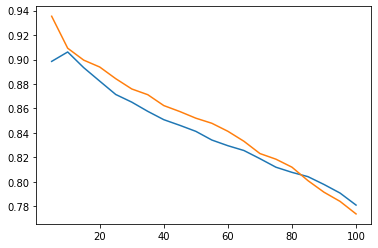

In [75]:
from matplotlib import pyplot as plt
plt.plot(np.arange(5,105,5),m.prec)
plt.plot(np.arange(5,105,5),m2.prec)

In [67]:
m.prec

array([0.12923077, 0.10923077, 0.11384615, 0.11846154, 0.12369231,
       0.12564103, 0.12395604, 0.12538462, 0.12410256, 0.12430769,
       0.12251748, 0.12307692, 0.1216568 , 0.12285714, 0.12184615,
       0.12115385, 0.12036199, 0.11863248, 0.11935223, 0.11830769])

In [49]:
2/(6/5+7/5)	

0.7692307692307694

In [121]:
m2.prec

array([0.89777778, 0.87888889, 0.85777778, 0.85333333, 0.84156653,
       0.83172363, 0.82339815, 0.81853713, 0.81177055, 0.80366726])

In [109]:
m.recall

array([0.0323474 , 0.06545172, 0.09725324, 0.12877512, 0.15998192,
       0.19176992, 0.22332875, 0.2550738 , 0.28745645, 0.31999064,
       0.35219086, 0.38534842, 0.41907966, 0.45240408, 0.48606165,
       0.52109181, 0.55690649, 0.59248445, 0.62860453, 0.66474594])

In [1]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2500, n_iter=5, random_state=42)

In [6]:
svd.fit(matrix)

TruncatedSVD(n_components=2500, random_state=42)

In [10]:
import pickle
pickle.dump(svd,open("./lsa.pkl","wb"))

In [7]:
svd.explained_variance_ratio_.sum()*100

95.07202506065369

In [11]:
m = svd.transform(matrix)

In [12]:

np.save("./compress_matrix.npy",m)

In [14]:
import aiosqlite
async def get_documents(document_ids):
	# command = "select ajName as case_name,ajjbqk as basic_fact,cpfxgc||pjjg as court_verdict from cases where id in ({})"\
	# 			.format(",".join([str(i) for i in document_ids]))
	# cur.execute(command)
	# return cur.fetchall()
	result = []
	db = await aiosqlite.connect("index.db")
	for document_id in document_ids:
		command = "select ajName as case_name,ajjbqk as basic_fact,cpfxgc||pjjg as court_verdict from cases where id = {}".format(document_id)
		cursor = await db.execute(command)
		row = await cursor.fetchone()
		result.append(row)
	await cursor.close()
	await db.close()
	return result

In [19]:
len(a[0])

3

In [13]:
svd = pickle.load(open("./lsa.pkl","rb"))

In [25]:
lsa_matrix = m

In [32]:
# lsa_matrix = np.load("./compress_matrix.npy")
def svd_query(key:str,n:int=5,ret_parse_key=False):
	key_with_count = pd.Series(list(jieba.cut(key))).value_counts().to_dict()
	_x = sparse.lil_matrix((len(words),1))
	# 生成查询向量的tf-idf
	for word in key_with_count:
		if word in words:
			pos = words_idx[word]
			_x[pos,0] = key_with_count[word] * np.log( (documents_length+1) / (1 + word_doc_count[pos]))
	x = _x.tocsr()
	x = svd.transform(x.T).T
	# 分词，利用倒排索引
	docuement_to_query = get_documents_matrix(key_with_count.keys())
	if len(docuement_to_query) == 0:
		if ret_parse_key:
			return [],key_with_count.keys()
		else:
			return ([],)
	elif len(docuement_to_query) < n:
		n = len(docuement_to_query)
	m = lsa_matrix[docuement_to_query]
	# 计算查询向量与文档向量的余弦相似度
	cosine_distance = (m@x).flatten()/(np.linalg.norm(m,axis=1) * np.linalg.norm(x))

	ind = np.argpartition(cosine_distance, -n)[-n:] # ind -> cosine
	unorder_result = cosine_distance[ind]
	result_order = np.flip(np.argsort(unorder_result))
	doc_ids = docuement_to_query[ind[result_order]]
	documents = get_documents(doc_ids)
	result = [{"id":int(i),"cosine_distance":float(j),"title":k[0],"fact":k[1],"verdict":k[2]} for i,j,k in zip(doc_ids,unorder_result[result_order],documents)]
	if ret_parse_key:
		return result,key_with_count.keys()
	else:
		return (result,)